this is a pig healthy/ill classification test using a neural network

In [16]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import pathlib
import matplotlib.pyplot as plt
import math

loading the data

In [17]:
# Set constants
size = 256
batch_size = 32
epochs = 35 #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading functions
def load_image(file, size):
    img = Image.open(file).convert('RGB')  # Convert to RGB
    img = img.resize((size, size))
    return np.array(img).flatten()

def load_labelled_images(path, size):
    labels = []
    files = []
    class_names = sorted([folder.name for folder in pathlib.Path(path).iterdir() if folder.is_dir()])  # Get folder names as class names
    label_encoder = LabelEncoder()
    label_encoder.fit(class_names)  # Fit label encoder to the class names
    print(f"Class names found: {class_names}")  # Debug print to check class names
    for folder in pathlib.Path(path).iterdir():
        if folder.is_dir():
            for file_info in folder.glob("*.jpg"):
                labels.append(folder.name)  # The folder name is the label
                files.append(str(file_info))
    print(f"Found {len(files)} image files.")  # Debug print to check number of image files
    imgs = np.array([load_image(f, size) for f in files])
    return imgs, np.array(labels), label_encoder


# Dataset class
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
    
    # Load data
images, labels, label_encoder = load_labelled_images("./data", size)

# Encode labels
encoded_labels = label_encoder.transform(labels)

# Normalize image data
images = images / 255.0  # Normalize to range [0, 1]

# Create dataset and dataloader
dataset = ImageDataset(images, encoded_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Class names found: ['Healthy', 'Infected_Bacterial_Erysipelas', 'Infected_Bacterial_Greasy_Pig_Disease', 'Infected_Environmental_Dermatitis', 'Infected_Environmental_Sunburn', 'Infected_Fungal_Pityriasis_Rosea', 'Infected_Fungal_Ringworm', 'Infected_Parasitic_Mange', 'Infected_Viral_Foot_and_Mouth_Disease', 'Infected_Viral_Swinepox']
Found 24510 image files.


neural network and training

In [18]:
# Simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.fc(x)


# Initialize the model
input_size = size * size * 3  # Flattened image size
num_classes = len(np.unique(encoded_labels))
model = SimpleNN(input_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate accuracy for the current batch
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # Calculate epoch accuracy
    accuracy = 100 * correct_predictions / total_predictions
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader):.4f}, Accuracy: {accuracy:.2f}%")

# Save the model
torch.save(model.state_dict(), "model.pth")

# Reload the model for inference
model.load_state_dict(torch.load("model.pth"))
model.to(device)

# Make predictions on the dataset (for simplicity, using training data here)
model.eval()
with torch.no_grad():
    predictions = []
    for inputs, _ in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())

# Calculate accuracy of predictions (using training data for simplicity)
correct_predictions = 0
total_predictions = 0
for i, label in enumerate(encoded_labels):
    if predictions[i] == label:
        correct_predictions += 1
    total_predictions += 1

final_accuracy = (correct_predictions / total_predictions) * 100
print(f"Final Model Accuracy: {final_accuracy:.2f}%")


Epoch 1/35, Loss: 3.2059, Accuracy: 12.25%
Epoch 2/35, Loss: 2.2706, Accuracy: 13.01%
Epoch 3/35, Loss: 2.2424, Accuracy: 14.66%
Epoch 4/35, Loss: 2.2217, Accuracy: 15.48%
Epoch 5/35, Loss: 2.2178, Accuracy: 15.78%
Epoch 6/35, Loss: 2.2027, Accuracy: 16.08%
Epoch 7/35, Loss: 2.1972, Accuracy: 16.53%
Epoch 8/35, Loss: 2.1906, Accuracy: 16.55%
Epoch 9/35, Loss: 2.1806, Accuracy: 16.95%
Epoch 10/35, Loss: 2.1759, Accuracy: 16.88%
Epoch 11/35, Loss: 2.1696, Accuracy: 17.01%
Epoch 12/35, Loss: 2.1634, Accuracy: 17.20%
Epoch 13/35, Loss: 2.1584, Accuracy: 17.52%
Epoch 14/35, Loss: 2.1546, Accuracy: 17.61%
Epoch 15/35, Loss: 2.1495, Accuracy: 17.56%
Epoch 16/35, Loss: 2.1499, Accuracy: 17.68%
Epoch 17/35, Loss: 2.1422, Accuracy: 17.85%
Epoch 18/35, Loss: 2.1414, Accuracy: 18.32%
Epoch 19/35, Loss: 2.1382, Accuracy: 18.36%
Epoch 20/35, Loss: 2.1261, Accuracy: 18.80%
Epoch 21/35, Loss: 2.1251, Accuracy: 18.53%
Epoch 22/35, Loss: 2.1176, Accuracy: 18.82%
Epoch 23/35, Loss: 2.1208, Accuracy: 18.8

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_13420\1808010440.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


Final Model Accuracy: 10.25%


visualization of the model

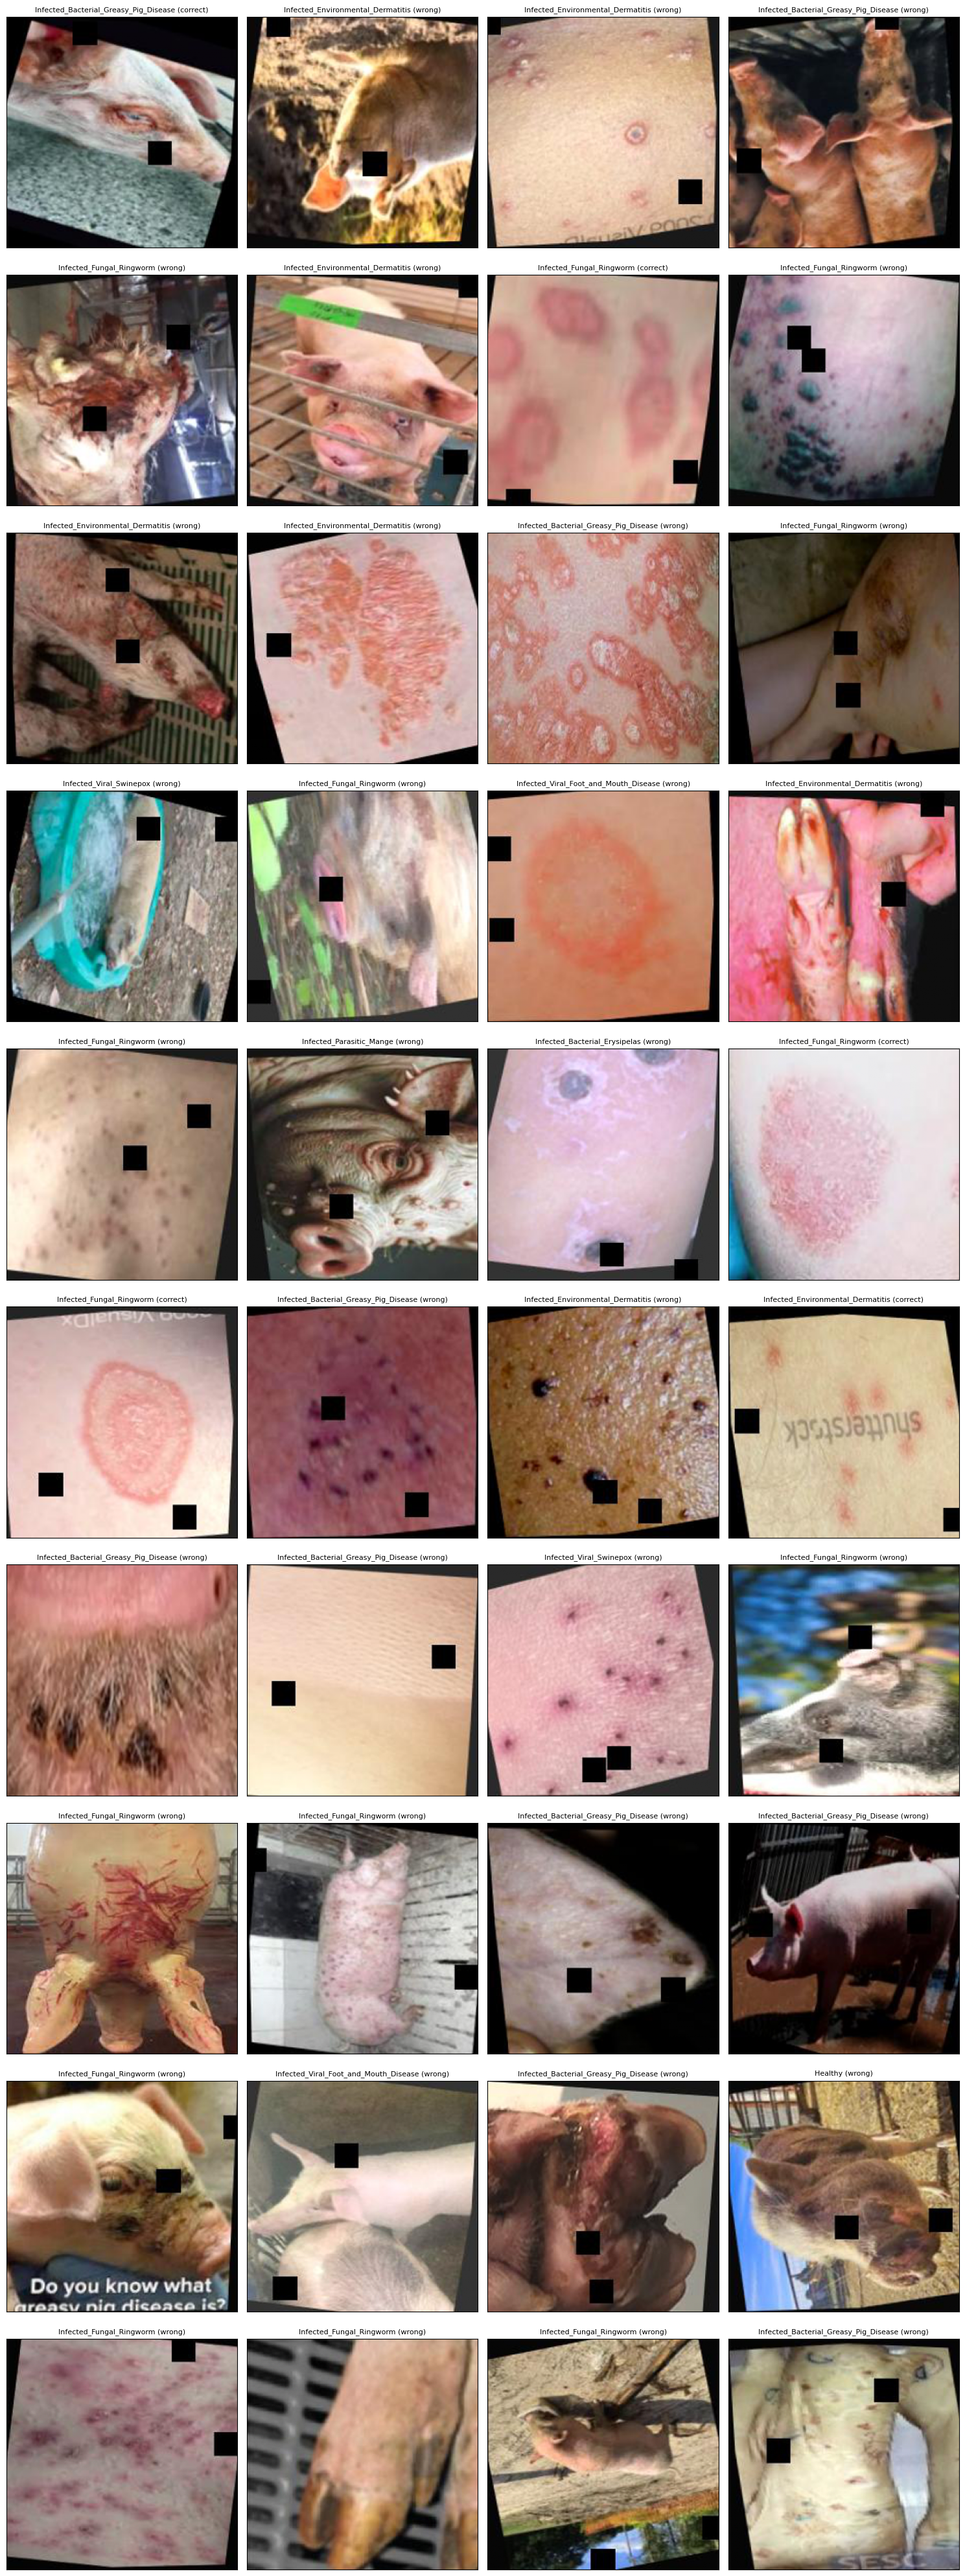

In [19]:
# Visualize predictions


def visualize_predictions(X_test, y_test, predictions, size, label_encoder, num_samples=40):
    # Decode the ground truth and predictions to class names (folder names)
    decoded_y_test = label_encoder.inverse_transform(y_test)
    decoded_predictions = label_encoder.inverse_transform(predictions)
    
    # Randomly select num_samples examples
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    X_test_sampled = X_test[indices]
    y_test_sampled = y_test[indices]
    predictions_sampled = [predictions[i] for i in indices]
    decoded_y_test_sampled = [decoded_y_test[i] for i in indices]
    decoded_predictions_sampled = [decoded_predictions[i] for i in indices]
    
    # Determine grid size
    rows = math.ceil(num_samples / 4)
    cols = 4
    fig, subplots = plt.subplots(nrows=rows, ncols=cols, figsize=(15, rows * 4))
    subplots = subplots.flatten()

    for i, x in enumerate(X_test_sampled):
        ax = subplots[i]
        img = np.reshape(x, (size, size, 3))
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])

        # Title includes prediction and ground truth
        predicted_label = decoded_predictions_sampled[i]
        true_label = decoded_y_test_sampled[i]
        correct = " (correct)" if predicted_label == true_label else " (wrong)"
        ax.set_title(f"{predicted_label}{correct}", fontsize=8)

    # Turn off unused subplots
    for j in range(len(X_test_sampled), len(subplots)):
        subplots[j].axis('off')

    plt.tight_layout()
    plt.show()

# Prepare test data and visualize (use the training data as a test set for simplicity)
X_test = images  # Replace with your actual test data
y_test = encoded_labels  # Replace with your actual test labels
visualize_predictions(X_test, y_test, predictions, size, label_encoder)
